In [10]:
import os
import json
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# --- Configuration ---
GROUP_NAME = "meat"
BASE_DIR = "data/classification_data"

# Paths
DATA_GROUP_DIR = os.path.join(BASE_DIR, GROUP_NAME)
IMAGES_DIR = os.path.join(DATA_GROUP_DIR, "images")
TRAIN_IMAGES_DIR = os.path.join(IMAGES_DIR, "train")
VAL_IMAGES_DIR = os.path.join(IMAGES_DIR, "val")
TRAIN_LABELS_PATH = os.path.join(DATA_GROUP_DIR, f"{GROUP_NAME}_labels_train.csv")
VAL_LABELS_PATH = os.path.join(DATA_GROUP_DIR, f"{GROUP_NAME}_labels_val.csv")
CLASS_MAPPING_PATH = "pipeline_data/dicts/classification_groups.json"

In [ ]:
class CustomFoodDataset(Dataset):
    """
    A custom PyTorch Dataset to load images from a directory and labels from a CSV file.
    """
    def __init__(self, csv_file, img_dir, group_name, class_map_path, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        with open(class_map_path, 'r') as f:
            class_groups = json.load(f)
        
        self.class_mapping = class_groups[group_name]
        self.labels_df['class_id'] = self.labels_df['class_id'].astype(int)
        
        self.num_classes = len(self.class_mapping)

    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx): 
        img_name = self.labels_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = self.labels_df.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)

        return image, label


## Helper functions for visualizations

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Denormalization Function ---
def denormalize(tensor):

    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    
    denorm_tensor = tensor.clone().cpu().numpy()
    
    denorm_tensor = denorm_tensor.transpose((1, 2, 0)) 
    
    denorm_tensor = denorm_tensor * STD + MEAN
    
    denorm_tensor = np.clip(denorm_tensor, 0, 1)
    
    return denorm_tensor

def get_class_name(label_id, group_name, class_map_path="pipeline_data/dicts/classification_groups.json"):
    """Maps a class ID back to its string name."""
    import json
    with open(class_map_path, 'r') as f:
        class_groups = json.load(f)
    
    return class_groups[group_name].get(str(label_id.item()), "Unknown Class")

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),       
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),               
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
train_dataset = CustomFoodDataset(
    csv_file=TRAIN_LABELS_PATH, 
    img_dir=TRAIN_IMAGES_DIR, 
    group_name=GROUP_NAME, 
    class_map_path=CLASS_MAPPING_PATH,
    transform=train_transforms
)

val_dataset = CustomFoodDataset(
    csv_file=VAL_LABELS_PATH, 
    img_dir=VAL_IMAGES_DIR, 
    group_name=GROUP_NAME, 
    class_map_path=CLASS_MAPPING_PATH,
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

NUM_CLASSES = train_dataset.num_classes
print(f"Number of classes for '{GROUP_NAME}': {NUM_CLASSES}")

Number of classes for 'meat': 11


Label ID: 1, Class Name: beef


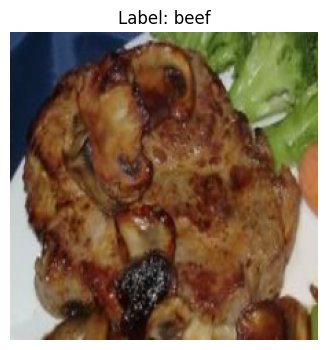

In [15]:
## visualize a sample image with label
import matplotlib.pyplot as plt
image, label = train_dataset[0]
denorm_image = denormalize(image)
class_name = get_class_name(label, GROUP_NAME)
print(f"Label ID: {label.item()}, Class Name: {class_name}")
plt.figure(figsize=(4,4))
plt.imshow(denorm_image)
plt.title(f"Label: {class_name}")
plt.axis('off') 
plt.show()

In [ ]:
import os
from ultralytics import YOLO

meat_model = YOLO("classification_models/YOLO/meat.pt")
meat_dir = "data/test_pics/meat/pexels-pixabay-60616.jpg"

results = meat_model.predict(source=meat_dir, verbose=False)

Top 5 Predictions:
  chicken: 0.8273
  salmon: 0.1498
  beef: 0.0203
  sausage: 0.0025
  bacon-frying: 0.0001


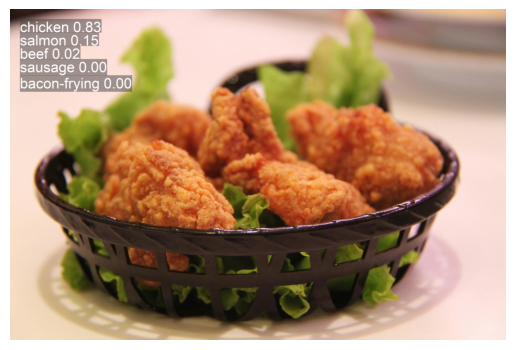

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

for result in results:
    names= result.names
    probs= result.probs
    top5cls = probs.top5
    top5probs = probs.top5conf
    
    print("Top 5 Predictions:")
    for cls, conf in zip(top5cls, top5probs):
        class_name = names[cls]
        confidence = conf.item()
        print(f"  {class_name}: {confidence:.4f}")
    im_array = result.plot()
    img_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()


#### TESTING COUNTOUR DETECTION

In [149]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

class ContourBoxDetector:
    """
    Detects contours in an image, generates bounding boxes,
    filters small boxes, removes boxes contained in larger ones,
    and optionally visualizes results.
    """

    def __init__(self, 
                 min_area_ratio=0.0005,
                 containment_threshold=0.5,
                 max_aspect_ratio=5.0,
                 visualize=True,
                 canny_thresholds=(50,150)):
        self.min_area_ratio = min_area_ratio
        self.containment_threshold = containment_threshold
        self.max_aspect_ratio = max_aspect_ratio
        self.visualize = visualize
        self.canny_thresholds = canny_thresholds
    # -------------------------
    # Helper methods
    # -------------------------

    @staticmethod
    def box_area(box: Tuple[int,int,int,int]) -> int:
        x1, y1, x2, y2 = box
        return max(0, x2 - x1) * max(0, y2 - y1)

    @staticmethod
    def intersection(boxA, boxB):
        x1 = max(boxA[0], boxB[0])
        y1 = max(boxA[1], boxB[1])
        x2 = min(boxA[2], boxB[2])
        y2 = min(boxA[3], boxB[3])
        if x1 < x2 and y1 < y2:
            return (x1, y1, x2, y2)
        return None

    @classmethod
    def containment_ratio(cls, small_box, large_box) -> float:
        inter = cls.intersection(small_box, large_box)
        if inter is None:
            return 0
        return cls.box_area(inter) / cls.box_area(small_box)

    @staticmethod
    def min_area_for_image(image_shape, ratio: float) -> float:
        h, w = image_shape[:2]
        return h * w * ratio

    # -------------------------
    # Filtering methods
    # -------------------------

    def filter_small_boxes(self, boxes: List[Tuple[int,int,int,int]], image_shape) -> List[Tuple[int,int,int,int]]:
        min_area = self.min_area_for_image(image_shape, self.min_area_ratio)
        return [b for b in boxes if self.box_area(b) >= min_area]

    def remove_subsumed_boxes(self, boxes: List[Tuple[int,int,int,int]]) -> List[Tuple[int,int,int,int]]:
        keep = []
        removed = set()
        for i, boxA in enumerate(boxes):
            if i in removed:
                continue
            for j, boxB in enumerate(boxes):
                if i == j or j in removed:
                    continue
                if self.box_area(boxA) < self.box_area(boxB):
                    small, large, small_idx = boxA, boxB, i
                else:
                    small, large, small_idx = boxB, boxA, j
                if self.containment_ratio(small, large) >= self.containment_threshold:
                    removed.add(small_idx)
            if i not in removed:
                keep.append(boxA)
        return keep

    def postprocess_boxes(self, boxes: List[Tuple[int,int,int,int]], image_shape) -> List[Tuple[int,int,int,int]]:
        boxes = self.filter_small_boxes(boxes, image_shape)
        boxes = self.remove_subsumed_boxes(boxes)
        return boxes

    # -------------------------
    # Main method
    # -------------------------

    def detect(self, image_path: str) -> List[Tuple[int,int,int,int]]:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Cannot load image: {image_path}")

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5,5), 0)
        edges = cv2.Canny(blurred, self.canny_thresholds[0], self.canny_thresholds[1])
        edges = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=1)

        contours_info = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours_info[0] if len(contours_info) == 2 else contours_info[1]

        boxes = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if min(w,h) == 0 or max(w,h)/min(w,h) > self.max_aspect_ratio:
                continue
            boxes.append((x, y, x+w, y+h))

        boxes = self.postprocess_boxes(boxes, image.shape)

        if self.visualize:
            vis = image.copy()
            for i, (x1, y1, x2, y2) in enumerate(boxes):
                cv2.rectangle(vis, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(vis, f"#{i+1}", (x1, max(0, y1-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            plt.figure(figsize=(12,8))
            plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title(f"Detected boxes ({len(boxes)})")
            plt.show()

        return boxes

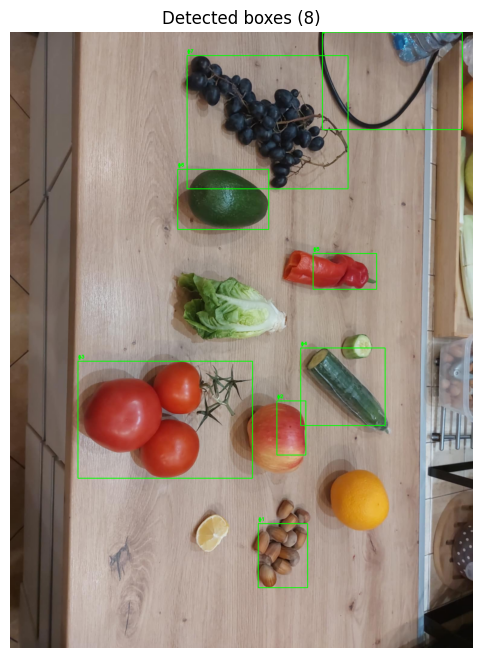

In [155]:
image_file = "data/test_pics/dom/dom3.jpg" 
detector = ContourBoxDetector(
        min_area_ratio=0.005,
        containment_threshold=0.5,
        max_aspect_ratio=3.5,
        visualize=True,
        canny_thresholds=(50,200)
    )

roi_boxes = detector.detect(image_file)


In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

class ClassificationModelManager:
    """
    Manages multiple classification models for different food categories."""
    def __init__(self, classification_paths: dict):
        self.classification_models = {}
        for category, path in classification_paths.items():
            try:
                self.classification_models[category] = YOLO(path)
            except Exception as e:
                print(f"Error loading model for category '{category}': {e}")
                self.classification_models[category] = None
        
    def get_model(self, category: str):
        return self.classification_models.get(category)
    
    def get_all_models(self):
        return self.classification_models
    
class MyFridgeModel:
    def __init__(self, detector: ContourBoxDetector,
                 detection_model_path: str, classification_config: dict,
                 detection_id_to_name: str, det_to_cls_group: str):
        
        self.detector = detector
        
        self.detection_model = YOLO(detection_model_path)

        self.cls_manager = ClassificationModelManager(classification_config)

        self.classification_models = self.cls_manager.get_all_models()

        with open(detection_id_to_name, 'r') as f:
            self.detection_id_to_name = json.load(f)

        with open(det_to_cls_group, 'r') as f:
            self.det_to_cls_group = json.load(f)

    def _expand_bbox(self, bbox, image_shape, scale=1.1):
        x1, y1, x2, y2 = bbox
        w, h = x2 - x1, y2 - y1
        cx, cy = x1 + w / 2, y1 + h / 2
        new_w, new_h = w * scale, h * scale

        x1n = max(0, int(cx - new_w / 2))
        y1n = max(0, int(cy - new_h / 2))
        x2n = min(image_shape[1] - 1, int(cx + new_w / 2))
        y2n = min(image_shape[0] - 1, int(cy + new_h / 2))

        return [x1n, y1n, x2n, y2n]
    
    def run(self, image_path: str, conf_threshold=0.3, det_imgsz=640,
            vis=False, vis_crops=False, verbose=True):
        """Run detection and classification on the input image."""
        image = cv2.imread(image_path)
        ### DETECTOR ### 
        roi_boxes = self.detector.detect(image_path)
        print(len(roi_boxes), "ROIs detected.")
        for box in roi_boxes:
            print(f"Detected ROI Box: {box}")
            expanded_box = self._expand_bbox(box, cv2.imread(image_path).shape)
            ex1, ey1, ex2, ey2 = expanded_box
            image = cv2.imread(image_path)
            crop_image = image[ey1:ey2, ex1:ex2].copy()

            image = crop_image
            if image is None:
                raise ValueError(f"Image at path '{image_path}' could not be loaded.")
            
            vis_img = image.copy() if vis else None

            ### DETECTION ###
            det_results = self.detection_model.predict(source=image, imgsz=det_imgsz, conf=conf_threshold, agnostic_nms=True, save=False, verbose=False)

            all_boxes = []
            final_outputs = []

            if vis:
                img_bgr = det_results[0].plot()
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(8, 8))
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.show()

            ### CLASSIFICATION ###

            for det in det_results:
                boxes = det.boxes.xyxy.cpu().numpy()
                class_ids = det.boxes.cls.cpu().numpy()
                scores = det.boxes.conf.cpu().numpy()

                for i, box in enumerate(boxes):
                    x1, y1, x2, y2 = map(int, box)
                    det_class_id = int(class_ids[i])
                    det_conf_score = float(scores[i])
                    det_class_name = self.detection_id_to_name[str(det_class_id)]

                    all_boxes.append((x1, y1, x2, y2, det_class_name, det_conf_score))

                    # --- Find which segmentation model to use ---
                    seg_group = None
                    for group_name, class_list in self.det_to_cls_group.items():
                        if det_class_name in class_list:
                            seg_group = group_name
                            if verbose:
                                print(f"Detection '{det_class_name}' mapped to classification group '{seg_group}'")
                            break
                    if seg_group is None:
                        if verbose:
                            print(f"No classification group found for detection '{det_class_name}'. Skipping classification.")
                        
                        final_outputs.append({
                            "bbox": [x1, y1, x2, y2],
                            "det_class_name": det_class_name,
                            "det_conf_score": det_conf_score,
                            "cls_group": None,
                            "top5_cls_results": []
                        })
                        continue

                    expanded_box = self._expand_bbox((x1, y1, x2, y2), image.shape)
                    ex1, ey1, ex2, ey2 = expanded_box
                    crop_img = image[ey1:ey2, ex1:ex2].copy()

                    cls_model = self.classification_models.get(seg_group)
                    if cls_model is None:
                        if verbose:
                            print(f"No classification model found for group '{seg_group}'. Skipping classification.")
                        
                        final_outputs.append({
                            "bbox": [x1, y1, x2, y2],
                            "det_class_name": det_class_name,
                            "det_conf_score": det_conf_score,
                            "cls_group": seg_group,
                            "top5_cls_results": []
                        })
                        continue

                    cls_results = cls_model.predict(source=crop_img, verbose=False)

                    ## Process classification results
                    top5 = []
                    if cls_results and cls_results[0].probs is not None:
                        cls_res = cls_results[0]

                        names = cls_res.names
                        top5cls_ids = cls_res.probs.top5
                        top5probs = cls_res.probs.top5conf

                        for idx, prob in zip(top5cls_ids, top5probs):
                            top5.append({
                                "class_name": names[idx],
                                "probability": float(prob)
                            })
                    final_outputs.append({
                        "bbox": [x1, y1, x2, y2],
                        "det_class_name": det_class_name,
                        "det_conf_score": det_conf_score,
                        "cls_group": seg_group,
                        "top5_cls_results": top5
                    })

                    if vis_crops:
                        for cls_res in cls_results:
                            im_array = cls_res.plot()
                            img_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
                            plt.figure(figsize=(6, 6))
                            plt.imshow(img_rgb)
                            plt.axis('off')
                            plt.show()

        return final_outputs

In [146]:
clsModelsDict = ({
    "meat": "classification_models/YOLO/meat.pt",
    "vegetable": "classification_models/YOLO/vegetable.pt",
    "fruit": "classification_models/YOLO/fruit.pt",
    "cheese-dairy" : "classification_models/YOLO/cheese-dairy.pt",
    "bread-pasta-grains": "classification_models/YOLO/bread-pasta-grains.pt",
    "nuts-seeds": "classification_models/YOLO/nuts-seeds.pt",
    "misc": "classification_models/YOLO/misc.pt",
})

detector = ContourBoxDetector(
        min_area_ratio=0.005,
        containment_threshold=0.5,
        max_aspect_ratio=3.5,
        visualize=True
    )


model = MyFridgeModel(
    detector=detector,
    detection_model_path="runs/detect/yolo_det_v4_m/weights/best.pt",
    classification_config=clsModelsDict,
    detection_id_to_name="pipeline_data/dicts/detect_classes_v4.json",
    det_to_cls_group="pipeline_data/dicts/det_to_cls_groups.json"
)

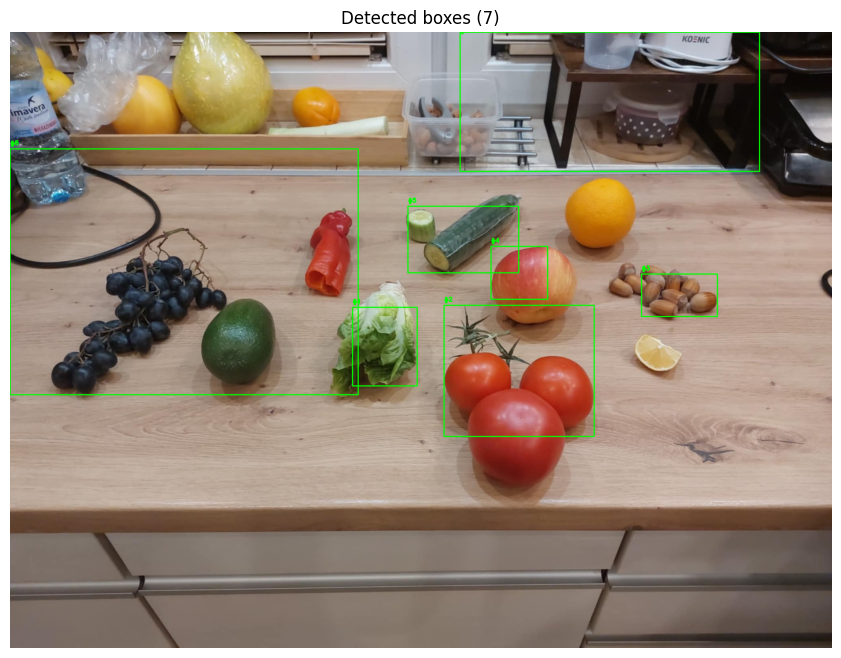

7 ROIs detected.
Detected ROI Box: (853, 686, 1014, 882)


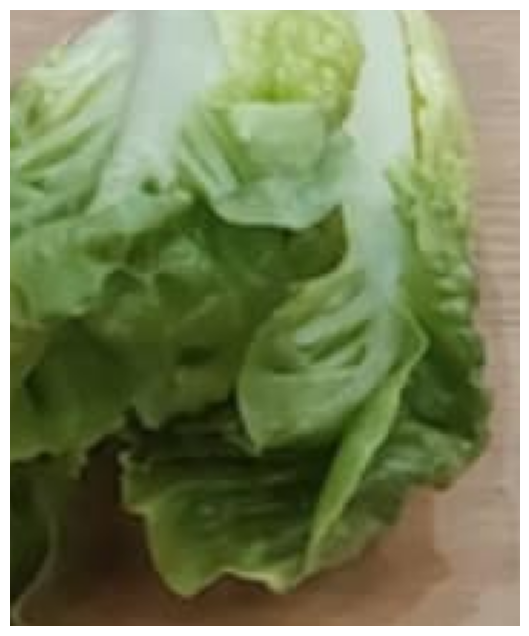

Detected ROI Box: (1081, 681, 1455, 1008)


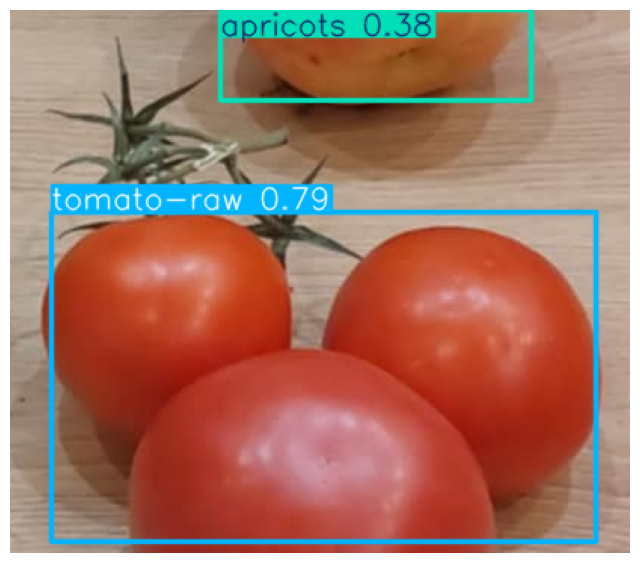

Detection 'tomato-raw' mapped to classification group 'vegetable'


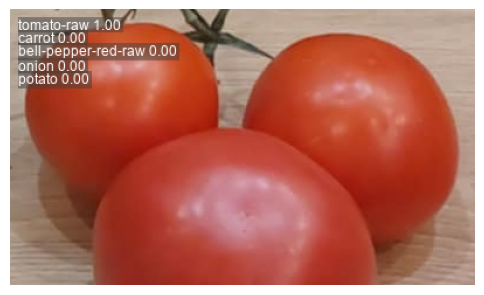

Detection 'apricots' mapped to classification group 'fruit'


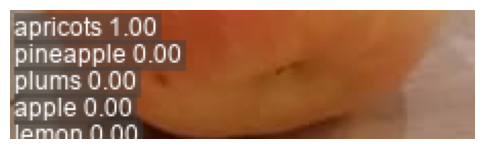

Detected ROI Box: (1573, 603, 1762, 709)


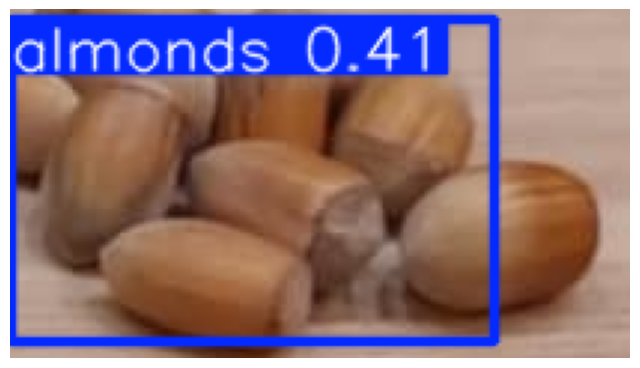

Detection 'almonds' mapped to classification group 'nuts-seeds'


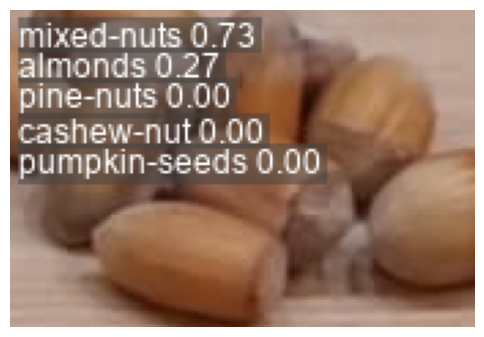

Detected ROI Box: (1198, 534, 1339, 666)


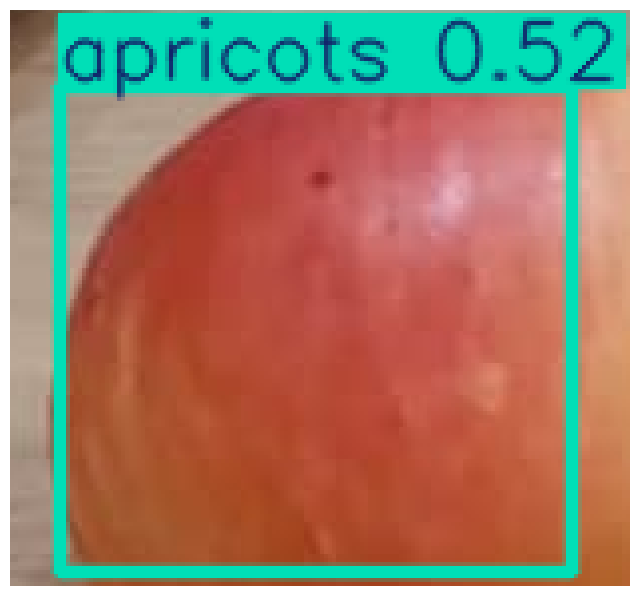

Detection 'apricots' mapped to classification group 'fruit'


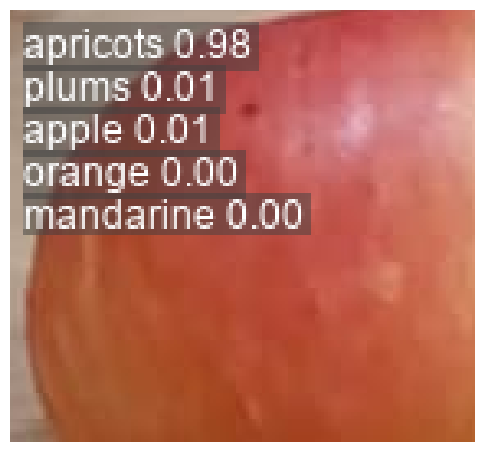

Detected ROI Box: (991, 434, 1267, 600)


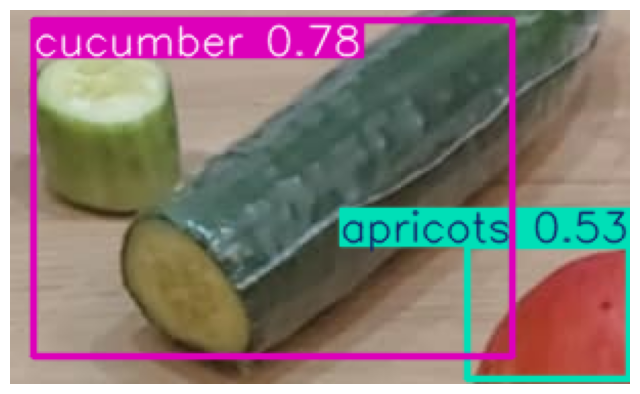

Detection 'cucumber' mapped to classification group 'vegetable'


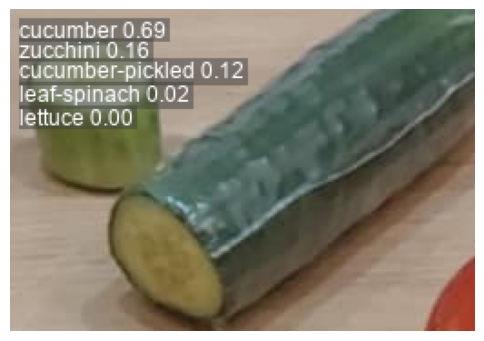

Detection 'apricots' mapped to classification group 'fruit'


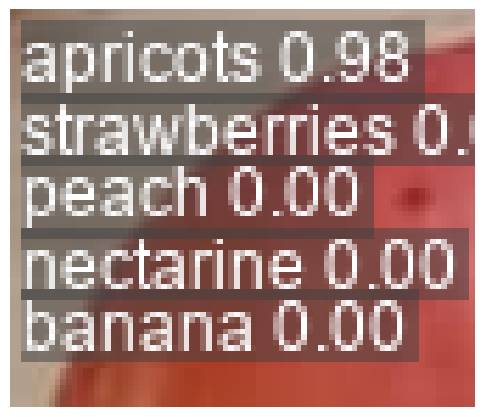

Detected ROI Box: (0, 291, 867, 904)


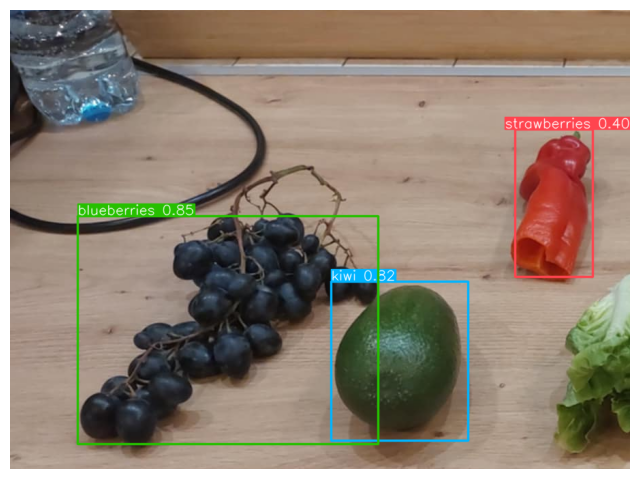

Detection 'blueberries' mapped to classification group 'fruit'


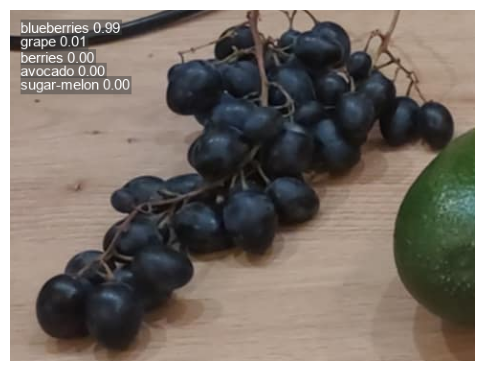

Detection 'kiwi' mapped to classification group 'fruit'


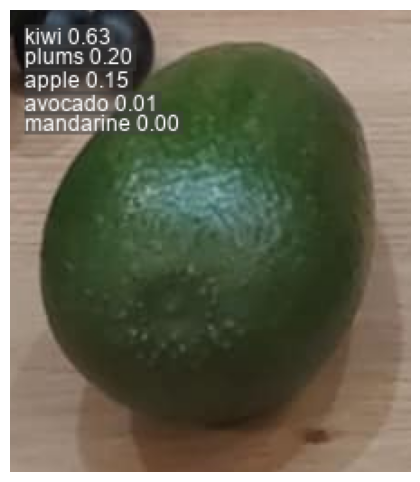

Detection 'strawberries' mapped to classification group 'fruit'


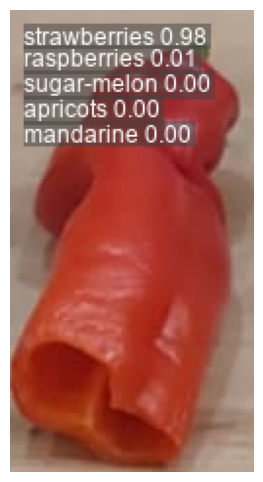

Detected ROI Box: (1121, 0, 1867, 347)


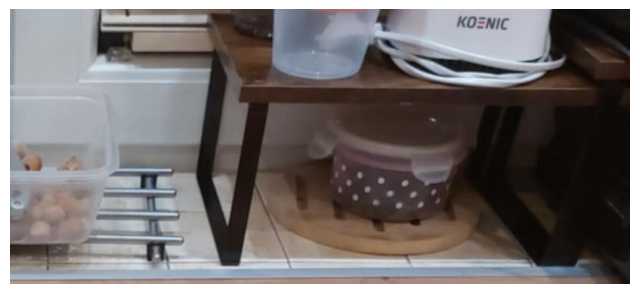

In [148]:
output = model.run(image_path="data/test_pics/dom/dom2.jpg", conf_threshold=0.3, det_imgsz=800,
          vis=True, vis_crops=True, verbose=True)

In [ ]:
from ultralytics import YOLO

model = YOLO("classification_models\\YOLO\\bread-pasta-grains.pt")
print(model.model)

ClassificationModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
